In [1]:
%load_ext autoreload
%autoreload 2

import fastai
from fastai import *
from fastai.vision import *

In [2]:
fastai.__version__

'1.0.57'

In [4]:
lesson_dir_path = Path('/home/justin/justinblaber/fastai_course/lesson1-pets')
data_dir_path = untar_data(URLs.PETS, dest=lesson_dir_path)

In [5]:
tfms = get_transforms()

In [6]:
data = (ImageList.from_folder(path=data_dir_path/'images')
                 .split_by_rand_pct(0.2, seed=1)
                 .label_from_re(r'/([^/]+)_\d+.jpg$')
                 .transform(tfms, size=224)
                 .databunch(path=data_dir_path)
                 .normalize(imagenet_stats))

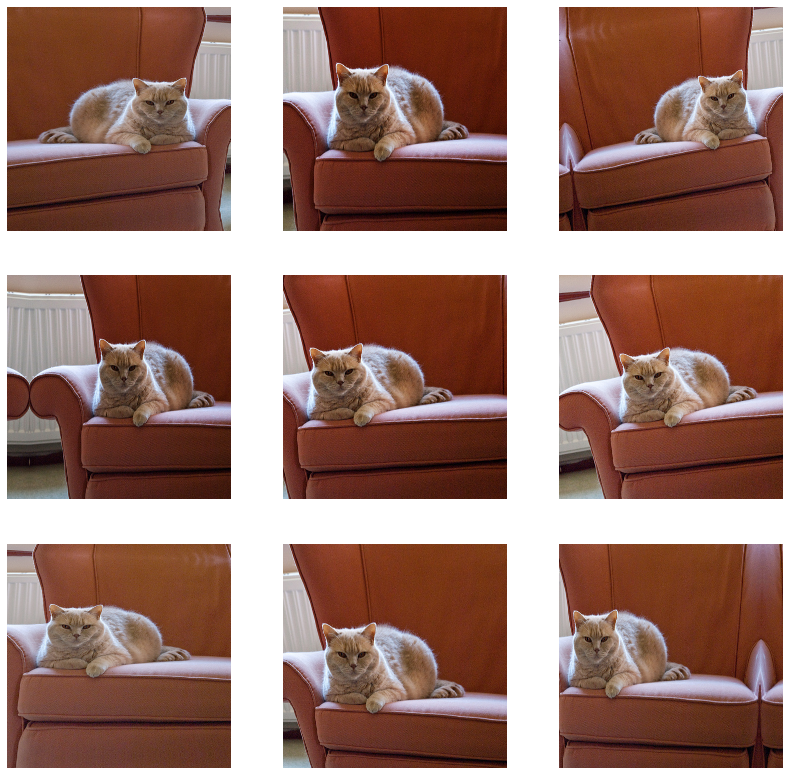

In [7]:
plot_multi(lambda i,j,ax : data.train_ds[0][0].show(ax), 3, 3, figsize=(14,14))

# Resnet34

### Try defaults

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/justin/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:26<00:00, 3.33MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


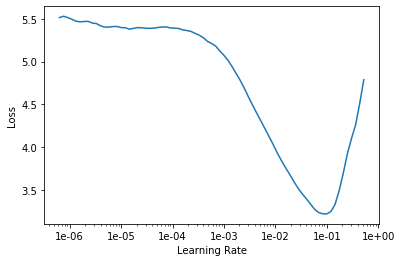

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.987978,0.415825,0.866035,00:22
1,0.699407,0.396337,0.890392,00:22
2,0.521267,0.364724,0.906631,00:22
3,0.349441,0.300008,0.918809,00:23
4,0.235329,0.260518,0.926928,00:22


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


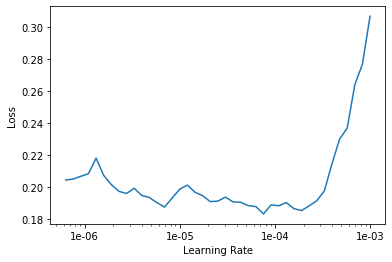

In [11]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.192754,0.284266,0.918809,00:29
1,0.212154,0.287638,0.925575,00:29
2,0.183638,0.279432,0.924899,00:29
3,0.136429,0.261297,0.930311,00:29
4,0.099560,0.258212,0.932341,00:29


In [13]:
learn.save('wd_0.01-do_0.5')

### Increase weight decay

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


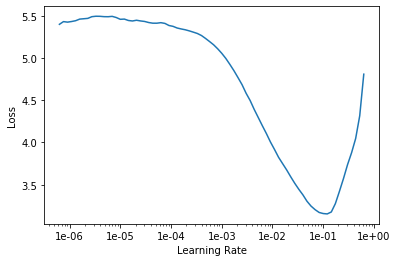

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.957209,0.440051,0.877537,00:22
1,0.655552,0.505072,0.878214,00:22
2,0.463641,0.294707,0.916103,00:23
3,0.310687,0.223330,0.934371,00:23
4,0.218574,0.205256,0.947226,00:22


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


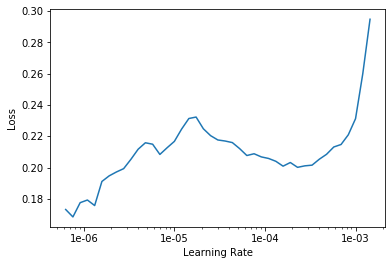

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.193740,0.213060,0.940460,00:29
1,0.190773,0.237524,0.927605,00:29
2,0.154135,0.241314,0.928281,00:29
3,0.116756,0.196734,0.942490,00:29
4,0.084054,0.190561,0.944520,00:29


In [19]:
learn.save('wd_0.1-do_0.5')

### Increase dropout

In [20]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, wd=1e-1, ps=0.7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


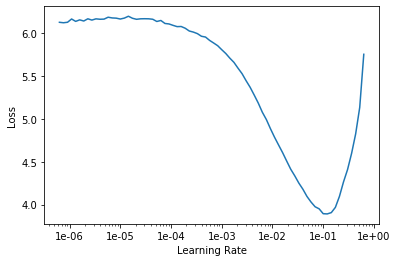

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.463196,0.398794,0.877537,00:23
1,0.848674,0.415031,0.883627,00:22
2,0.615760,0.289969,0.910014,00:22
3,0.450423,0.231975,0.930311,00:22
4,0.338254,0.216558,0.935047,00:22


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


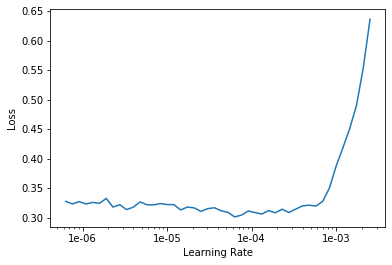

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.293160,0.231076,0.928958,00:30
1,0.292641,0.212196,0.933018,00:29
2,0.248202,0.206463,0.937077,00:29
3,0.194250,0.198257,0.942490,00:30
4,0.166572,0.196534,0.937077,00:30


In [25]:
learn.save('wd_0.1-do_0.7')

In [26]:
learn.export('resnet34.pkl')

# Do some analyses

In [27]:
learn = load_learner(data_dir_path, 'resnet34.pkl')
learn.load('wd_0.1-do_0.7')
learn.data = data  # Do this so same validation set is used

In [28]:
p = learn.get_preds()

In [29]:
y_pred = p[0].argmax(dim=1)
y_true = p[1]

### Plot confusion matrix

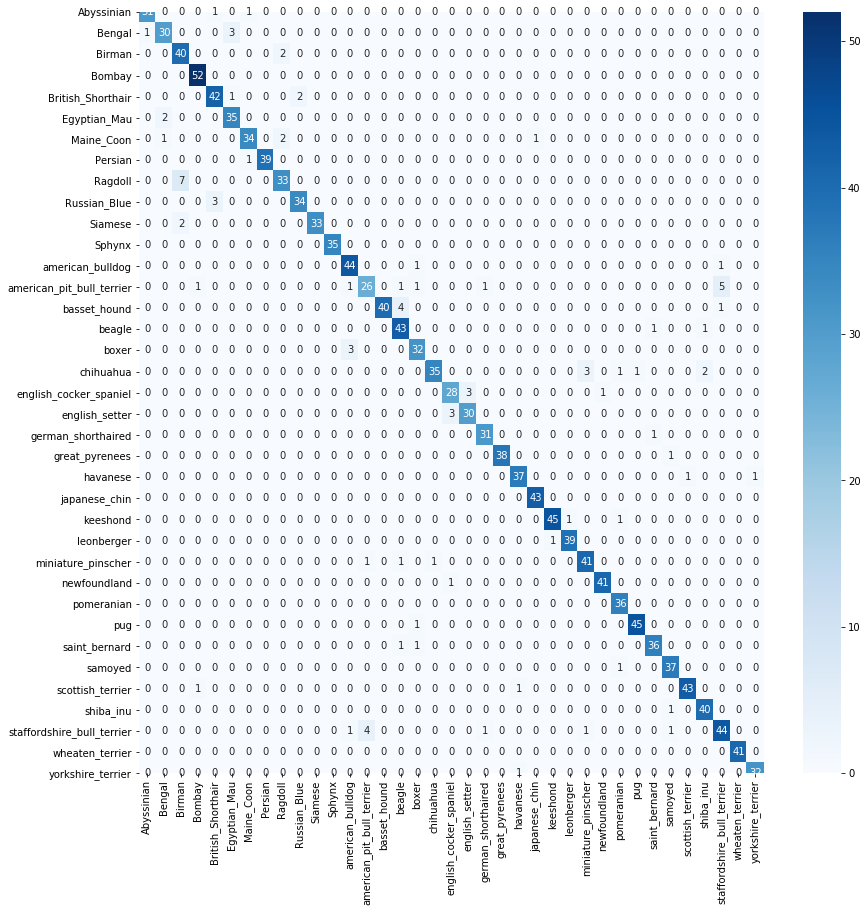

In [31]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=data.classes, columns=data.classes)
plt.figure(figsize=(14, 14))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)

### Get "most confused" classes

In [32]:
# Find max off diagonal element
min_val = 3

# Code from fastai
cm_od = cm.copy()
np.fill_diagonal(cm_od, 0)
mc = [(data.classes[i], data.classes[j], cm_od[i,j]) for i,j in zip(*np.where(cm_od > min_val))]
mc.sort(key = lambda x: x[2], reverse=True)
mc

[('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('basset_hound', 'beagle', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4)]

### Plot most confused side by side

In [33]:
# Get classes in validation set
v_classes = np.asarray([str(c) for c in data.valid_ds.y])

# Get most confused class name pair and indices
idx_mc = 0
mc_cls = mc[idx_mc][:-1]
idx_mc_cls = [np.where(v_classes == mc_cls[i])[0] for i in range(2)]

In [34]:
def _plot_sbs(nr, figsize):
    fig, axes = plt.subplots(nr, 2)
    fig.set_size_inches(figsize[0], figsize[1])
    for i in range(2):
        idx_r = np.random.choice(idx_mc_cls[i], nr)
        for j in range(nr):
            data.valid_ds[idx_r[j]][0].show(axes[j, i])
            axes[j, i].set_title(mc_cls[i])

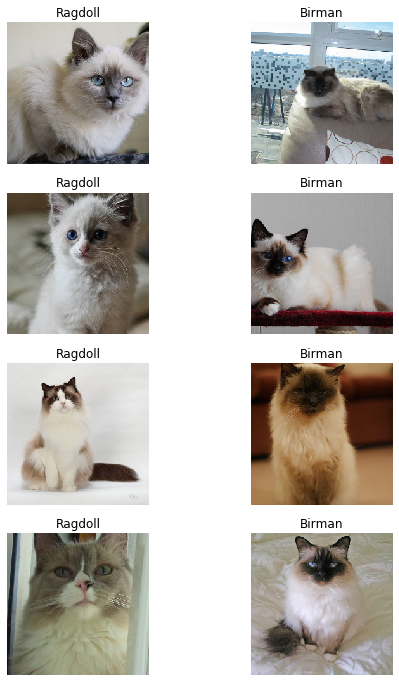

In [35]:
_plot_sbs(4, figsize=(8, 12))

#### They look similar... 

### Grad CAM

In [36]:
m = learn.model.eval().cpu()

In [37]:
idx = 1
x,y = data.valid_ds[idx]
xb = data.one_item(x)[0].cpu()

In [38]:
from fastai.callbacks import *

with hook_output(m[0]) as hook_a:
    with hook_output(m[0], grad=True) as hook_g:
        preds = m(xb)
        # Paper says to compute gradient of score for class before softmax
        preds[0, y.data].backward() 

In [39]:
def _compute_cam(acts):
    acts = acts.mean(dim=1, keepdim=True)
    return nn.functional.relu(acts)

In [40]:
# Just take mean activations
cam = _compute_cam(hook_a.stored)

In [41]:
# Scale channels by mean gradient
gradcam = _compute_cam(hook_a.stored * nn.functional.adaptive_avg_pool2d(hook_g.stored[0], 1))

In [42]:
def _format_cam(cam):
    cam = nn.functional.interpolate(cam, scale_factor=32, mode='bilinear', align_corners=True)
    cam = cam.squeeze(dim=0).squeeze(dim=0)
    return (cam-cam.min())/(cam.max()-cam.min())

In [43]:
# Get in same size as image and reshape so we can plot it
cam = _format_cam(cam)
cam.shape

torch.Size([224, 224])

In [44]:
# Get in same size as image and reshape so we can plot it
gradcam = _format_cam(gradcam)
gradcam.shape

torch.Size([224, 224])

In [45]:
def _plot_cam(ax, x, cam, title):
    x.show(ax=ax)
    ax.imshow(cam, alpha=0.6, cmap='magma')
    ax.set_title(title)

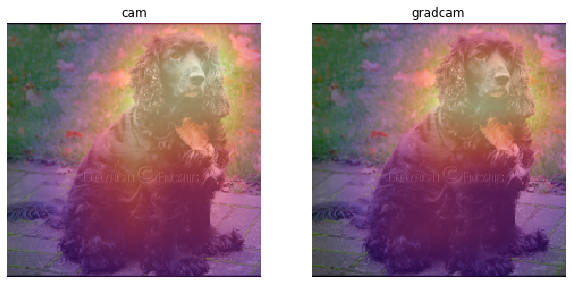

In [46]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 10)

_plot_cam(axes[0], x, cam, 'cam')
_plot_cam(axes[1], x, gradcam, 'gradcam')